<h3>Count of query terms aproximate number of results</h3>

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse
import time
from newspaper import Article
import json

def resultados_por_ano(query_term):
    sites = 'publico.pt,sapo.pt,jn.pt,observador.pt,expresso.pt'

    resultados = []
    titulos = []
    for i in range(2010, 2023):
        data = [int(f"{i}0101"), int(f"{i}1231")]
        

        site= f"https://arquivo.pt/textsearch?q={query_term}&prettyPrint=false&from={data[0]}&to={data[1]}&siteSearch={sites}"
        # json = requests.get(site).json()["response_items"]
        content = requests.get(site).json()
        resultados.append(content['estimated_nr_results'])
        # print(f"{query_term}, {i}, ok", end=" | ")
        #try:
        #    print(json[0]["linkToExtractedText"])
        #except:
        #    pass

    return resultados

df = pd.DataFrame({"anos": list(range(2010, 2023))})
# Query terms to search for
query_terms = [
    "Tesla", "carro elétrico", "Renault Zoe",
    "emissão zero",
    "mobilidade sustentável","poluição do ar" 
    #"Tesla Model 3", "Tesla Model Y",
]
for term in query_terms:
    df[term] = resultados_por_ano(term)

df

,anos,Tesla,carro elétrico,Renault Zoe,emissão zero,mobilidade sustentável,poluição do ar
0,2010,0,0,0,0,0,0
1,2011,0,0,0,5,0,6
2,2012,1,0,0,11,0,7
3,2013,0,0,0,36,19,73
4,2014,78,47,0,103,9,452
5,2015,17580,6660,0,250,266,1992
6,2016,62888,14418,11128,2456,1468,16876
7,2017,113383,5858,28044,1518,1765,7688
8,2018,75352,20763,13389,1703,1883,4870
9,2019,42978,18578,7804,6156,8813,14241


<h3>Code for webscraping websites</h3>

In [4]:
def extract_article_content(url):
    try:
        article = Article(url)
        article.download()
        article.parse()
        
        # return {
        #     "title": article.title,
        #     "text": article.text,
        #     "authors": article.authors,
        #     "publish_date": article.publish_date,
        #     "keywords": article.keywords if article.is_parsed else [],
        # }
        return article.text
    except Exception as e:
        print(f"Error extracting {url}: {e}")
        return None
    
def process_item(item,query_term):
    linkToArchive = item.get('linkToNoFrame')
    extracted_text = extract_article_content(linkToArchive)
    
    if extracted_text:
        return {
            "year": item.get('date')[:4],  # Assuming date is in YYYYMMDD format
            "query_term": query_term,
            "title": item.get('title'),
            "url": linkToArchive,
            "extracted_text": extracted_text
        }
    else:
        return None


# Function to get results from Arquivo.pt API and then filter by text content
def webscrapping(query_term):
    sites = 'publico.pt,sapo.pt,jn.pt,expresso.pt,observador.pt'
    textos_filtrados = []
    
    for i in range(2010, 2023):  # Loop through each year
        data = [int(f"{i}0101"), int(f"{i}1231")]
        offset = 0
        max_items = 500  # Maximum allowed per request

        print(f"Processing year {i} for query '{query_term}'")

        while True:

            site = f"https://arquivo.pt/textsearch?q={query_term}&prettyPrint=false&from={data[0]}&to={data[1]}&siteSearch={sites}&offset={offset}&maxItems={max_items}"
        
            try:
                response = requests.get(site)
                
                # Check if the response status is OK
                if response.status_code != 200:
                    print(f"Received HTTP {response.status_code} for year {i}, query '{query_term}' at offset {offset}. Skipping to next year.")
                    break  # Break the while loop and proceed to the next year

                try:
                    content = response.json()
                except ValueError as ve:
                    print(f"Error parsing JSON for year {i}, query '{query_term}' at offset {offset}: {ve}")
                    break  # Break the while loop and proceed to the next year

                items = content.get('response_items', [])
                
                for item in items:
                    linkToArchive = item.get('linkToNoFrame')
                    if not linkToArchive:
                        continue  # Skip if the link is missing

                    extracted_text = extract_article_content(linkToArchive)
                    
                    if extracted_text:
                        textos_filtrados.append({
                            "year": i,
                            "query_term": query_term,
                            "title": item.get('title', ''),
                            "url": linkToArchive,
                            "extracted_text": extracted_text
                        })

                if not items:
                    print(f"No more items returned at offset {offset}. Stopping.")
                    break 


                items_fetched = len(items)
                offset += items_fetched
                print(f"Fetched {items_fetched} items at offset {offset}")
                
                # Optional delay to respect rate limits
                time.sleep(1)

                # If fewer items are returned than max_items, we've reached the last page
                if items_fetched < max_items:
                    print(f"Last page reached with {items_fetched} items.")
                    break

            except Exception as e:
                print(f"Error processing year {i} for query {query_term}: {e}")
        # After processing each year
        with open(f"textos_filtrados_{query_term}_{i}.json", "w", encoding='utf-8') as f:
            json.dump(textos_filtrados, f, ensure_ascii=False, indent=4)
        
    return textos_filtrados

# Query terms to search for
query_terms = [
    "Tesla", "carro elétrico", "Renault Zoe",
    "emissão zero",
    "mobilidade sustentável","poluição do ar" 
    #"Tesla Model 3", "Tesla Model Y",
]

# Dictionary to store filtered texts for each query
filtered_texts = []

# Loop through each query term and collect data
for term in query_terms:
    textos_filtrados = webscrapping(term)
    filtered_texts.extend(textos_filtrados)
    print(f"Finished processing {term}")

# Convert the filtered texts into a DataFrame
df_articles = pd.DataFrame(filtered_texts)

# Grouping by year and query term to count the number of articles per year for each term
df_article_counts = df_articles.groupby(["year", "query_term"]).size().unstack(fill_value=0)

# Display the article count DataFrame (one column per query term, one row per year)
print(df_article_counts)

# Save the articles DataFrame to CSV for future analysis if needed
df_articles.to_csv("extracted_articlesv4.csv", index=False)

# Save the article counts to another CSV
df_article_counts.to_csv("article_counts_by_yearv4.csv")

df_articles.head()


Processing year 2010 for query 'Tesla'
No more items returned at offset 0. Stopping.
Processing year 2011 for query 'Tesla'
No more items returned at offset 0. Stopping.
Processing year 2012 for query 'Tesla'
Fetched 1 items at offset 1
Last page reached with 1 items.
Processing year 2013 for query 'Tesla'
No more items returned at offset 0. Stopping.
Processing year 2014 for query 'Tesla'
Fetched 53 items at offset 53
Last page reached with 53 items.
Processing year 2015 for query 'Tesla'
Fetched 500 items at offset 500
Fetched 229 items at offset 729
Last page reached with 229 items.
Processing year 2016 for query 'Tesla'
Fetched 500 items at offset 500
Fetched 500 items at offset 1000
Fetched 500 items at offset 1500
Fetched 465 items at offset 1965
Last page reached with 465 items.
Processing year 2017 for query 'Tesla'
Fetched 500 items at offset 500
Fetched 500 items at offset 1000
Fetched 500 items at offset 1500
Fetched 500 items at offset 2000
Fetched 1 items at offset 2001
La

,year,query_term,title,url,extracted_text
0,2014,Tesla,A Tesla vai instalar postos de super carregame...,https://arquivo.pt/noFrame/replay/201410230816...,"Em 2015, a Península Ibérica vai ter uma rede ..."
1,2014,Tesla,,https://arquivo.pt/noFrame/replay/201410230817...,O Governo tem até quarta-feira para entregar n...
2,2014,Tesla,Pedro Esteves - Observador,https://arquivo.pt/noFrame/replay/201410221351...,"Comecei a fazer Rádio em 1987, no tempo das ""p..."
3,2014,Tesla,Pedro Esteves - 2/10455 - Observador,https://arquivo.pt/noFrame/replay/201410221351...,"Comecei a fazer Rádio em 1987, no tempo das ""p..."
4,2014,Tesla,nanoFLOWCELL: uma nova tecnologia que promete ...,https://arquivo.pt/noFrame/replay/201412020223...,A empresa suíça nanoFLOWCELL desenvolveu um pr...


<h1>Clean the Web Scrapped Data</h1>
<h2>Remove Missing Values and duplicates</h2>

In [1]:
import pandas as pd
import glob
import os
import json

# Define the directory where your CSV files are stored
data_directory = ''

all_files = glob.glob(os.path.join(data_directory, "textos_filtrados_*.json"))

df_list = []

for file in all_files:
    with open(file, "r", encoding='utf-8') as f:
        data = json.load(f)
        df_list.append(pd.DataFrame(data))

df_combined = pd.concat(df_list, ignore_index=True)

print(f"Total number of articles before cleaning: {len(df_combined)}")


# Check for missing values
missing_values = df_combined.isnull().sum()
print("Missing values before cleaning:")
print(missing_values)

# Drop rows where 'extracted_text' is missing or empty
df_cleaned = df_combined.dropna(subset=['extracted_text'])

print(f"Total number of articles after dropping missing texts: {len(df_cleaned)}")

# Remove duplicates based on 'url'
df_cleaned = df_cleaned.drop_duplicates(subset='url')
print(f"Total number of articles after removing duplicates: {len(df_cleaned)}")


Total number of articles before cleaning: 176412
Missing values before cleaning:
year              0
query_term        0
title             0
url               0
extracted_text    0
dtype: int64
Total number of articles after dropping missing texts: 176412
Total number of articles after removing duplicates: 32105


<h2>Standardize Data</h2>

In [2]:
import re
import string

# Enhanced Cleaning Function
def clean_text_spacy(text):
    if not isinstance(text, str):
        return ''
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove non-alphabetic characters (retain spaces and accented characters)
    text = re.sub(r'[^a-zA-ZÀ-ÿ\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

# Apply the cleaning function to 'extracted_text' and 'title'
df_cleaned['cleaned_text'] = df_cleaned['extracted_text'].apply(clean_text_spacy)
df_cleaned['cleaned_title'] = df_cleaned['title'].apply(clean_text_spacy)

<h1>Extract keywords</h1>

In [3]:
import spacy
from collections import Counter
import csv

# Load the Portuguese model
nlp = spacy.load('pt_core_news_sm')

stopwords_file = 'stopwords.txt'  # Update the path if necessary
with open(stopwords_file, 'r', encoding='utf-8') as file:
    custom_stopwords = [line.strip().lower() for line in file if line.strip()]

for word in custom_stopwords:
    nlp.Defaults.stop_words.add(word.lower())  # Ensure all stopwords are lowercase
    nlp.vocab[word.lower()].is_stop = True  # Mark the word as a stopword in the vocabulary


def tokenize_remove_stopwords_lemmatize(text):
    doc = nlp(text)
    tokens = [
        token.lemma_ for token in doc
        if not token.is_stop
        and token.is_alpha
        and len(token.text) > 1  # Exclude single-letter tokens
    ]
    return tokens

def extract_keywords_spacy(tokens, top_n=10):
    # Frequency-based keyword extraction
    counter = Counter(tokens)
    common = counter.most_common(top_n)
    keywords = [word for word, freq in common]
    return keywords


# Tokenize and remove stopwords
df_cleaned['tokens'] = df_cleaned['cleaned_text'].apply(tokenize_remove_stopwords_lemmatize)
    
# Extract keywords
df_cleaned['keywords'] = df_cleaned['tokens'].apply(lambda tokens: extract_keywords_spacy(tokens, top_n=10))

# Reorder columns if necessary
desired_order = ['year','query_term', 'title', 'cleaned_title', 'url', 'extracted_text', 'cleaned_text', 'tokens', 'keywords','lemmatized_text']
df_cleaned = df_cleaned.reindex(columns=desired_order)

# Save the DataFrame with proper quoting
df_cleaned.to_csv(
    'cleaned_articles_spacy.csv',
    index=False,
    encoding='utf-8',
    quoting=csv.QUOTE_ALL  # Ensures that all fields are quoted
)

df_cleaned.to_json('cleaned_articles_spacy.json', orient='records', lines=True, force_ascii=False)

print("Data cleaning complete. Cleaned data saved to 'cleaned_articles_spacy.csv'")

Data cleaning complete. Cleaned data saved to 'cleaned_articles_spacy.csv'


<h1>Visualizing Data</h1>

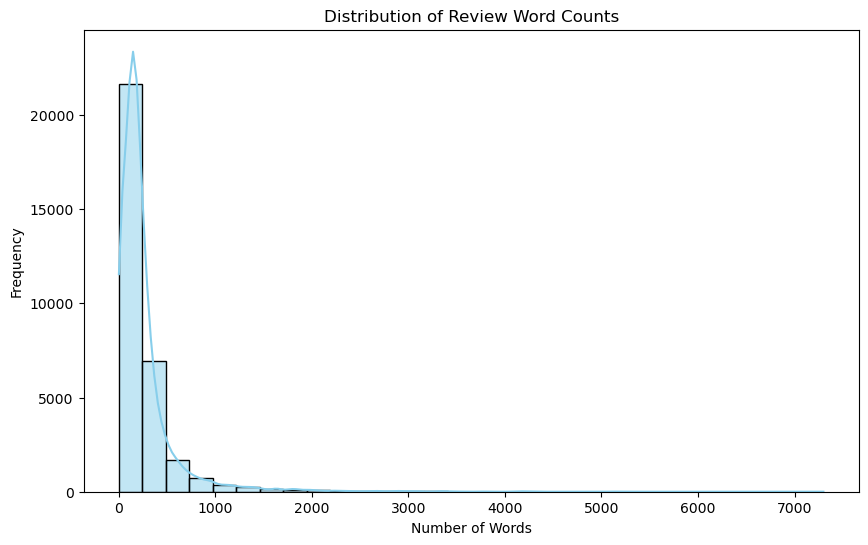

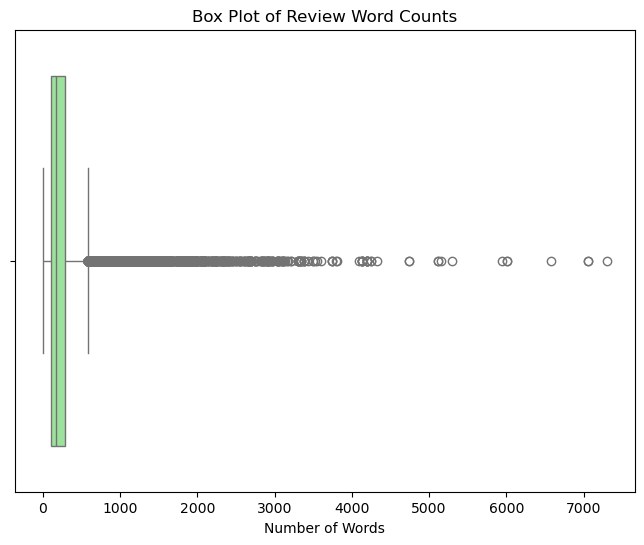

C:\Users\FF\AppData\Local\Temp\ipykernel_30512\2744961129.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette='viridis')


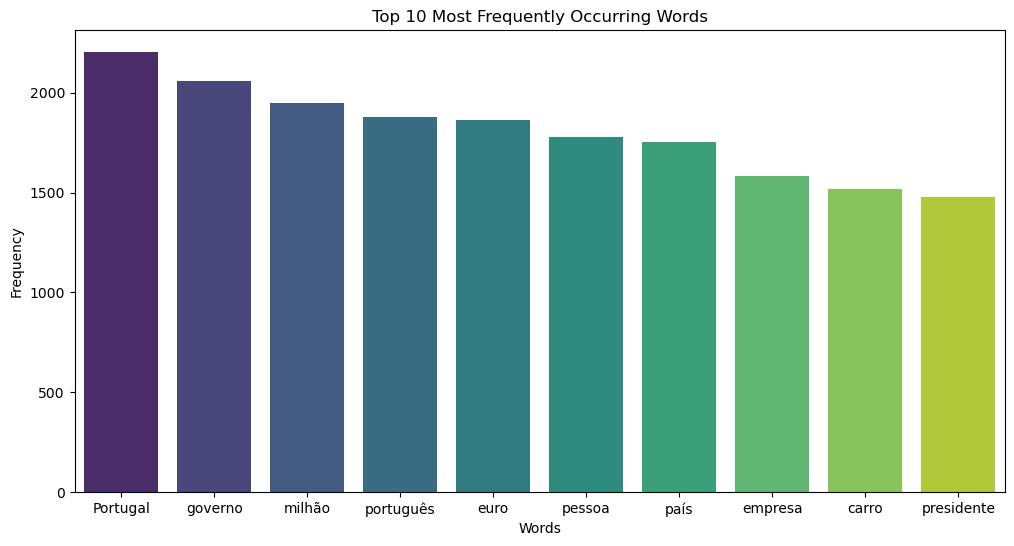

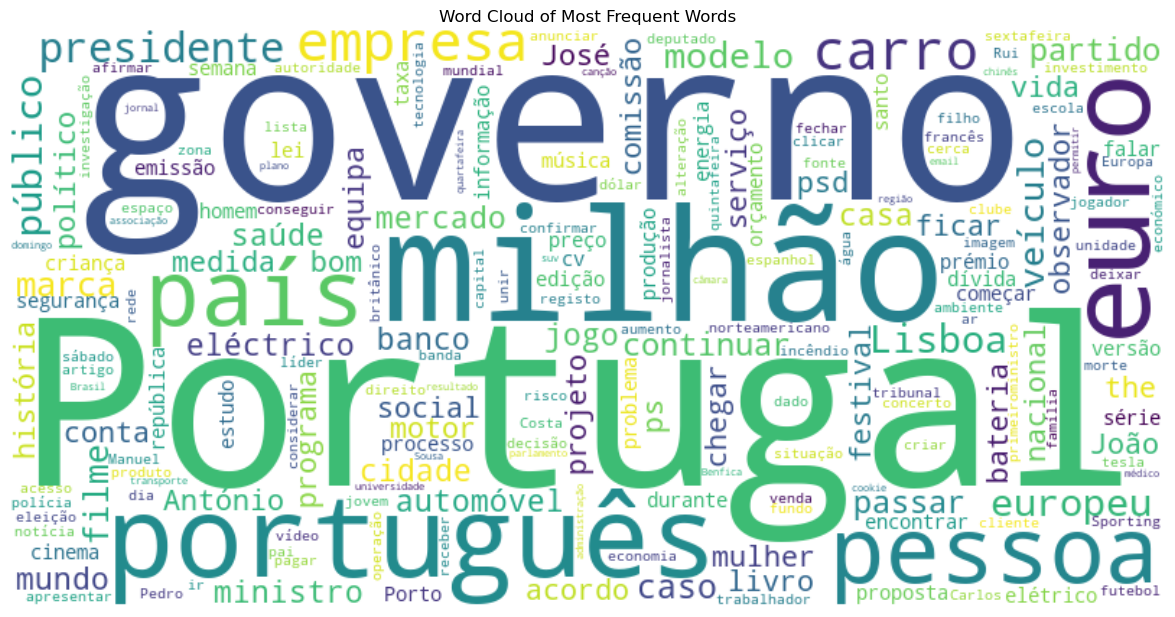

C:\Users\FF\AppData\Local\Temp\ipykernel_30512\2744961129.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(bigrams), y=list(bigram_counts), palette='magma')


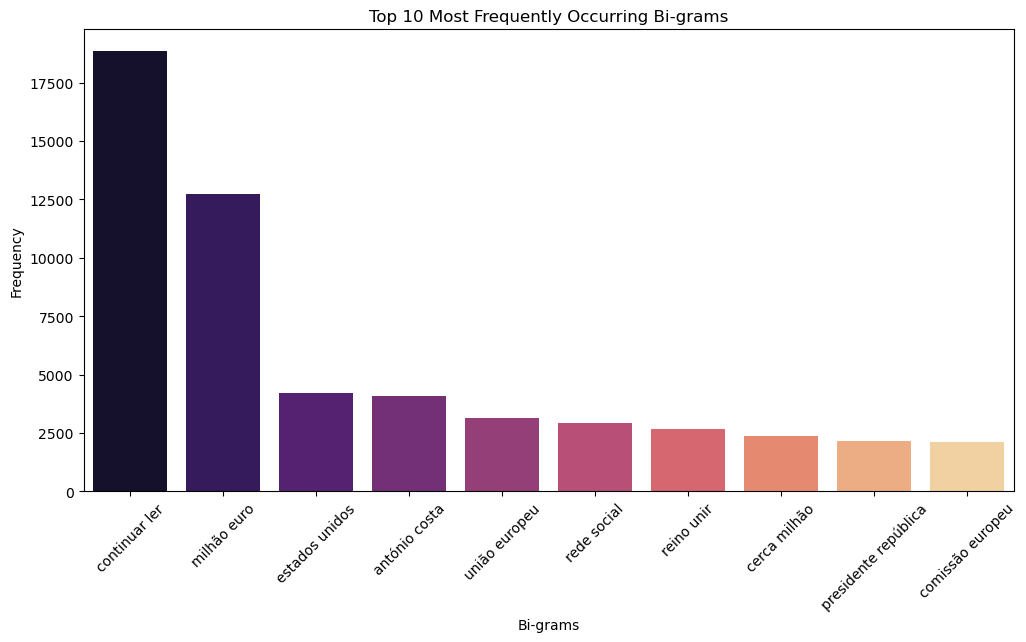

C:\Users\FF\AppData\Local\Temp\ipykernel_30512\2744961129.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(trigrams), y=list(trigram_counts), palette='coolwarm')


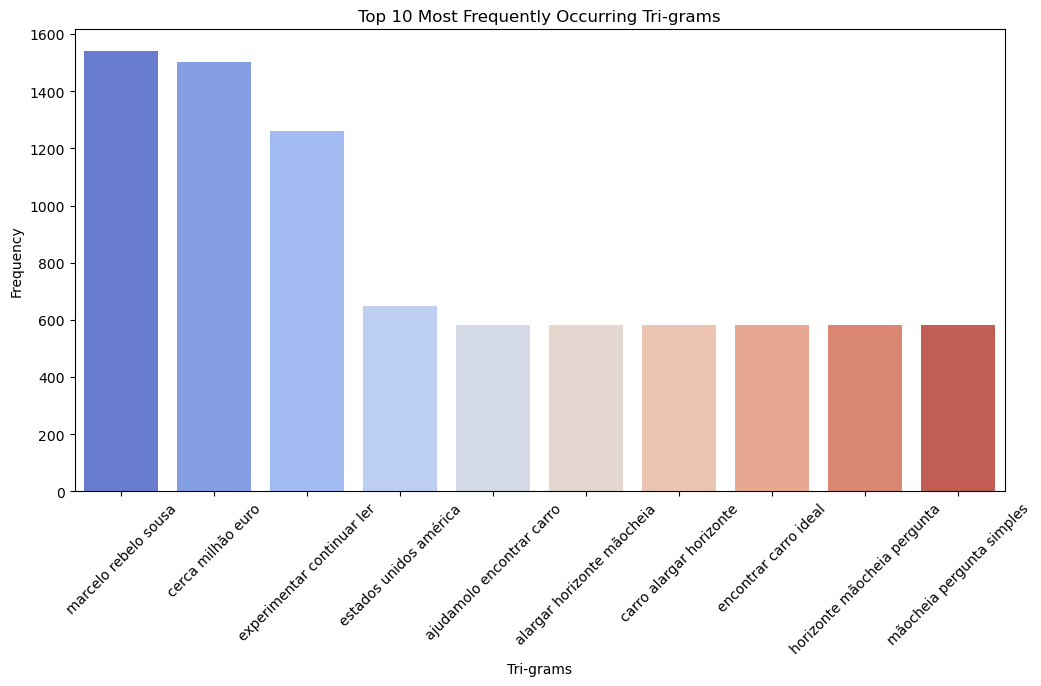

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.util import ngrams
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import spacy
from wordcloud import WordCloud
import json

# Load the Portuguese model
nlp = spacy.load('pt_core_news_sm')

df_cleaned = pd.read_json('cleaned_articles_spacy.json', orient='records', lines=True)
df_cleaned['word_count'] = df_cleaned['tokens'].apply(len)

plt.figure(figsize=(10,6))
sns.histplot(df_cleaned['word_count'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Review Word Counts')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# Plot box plot
plt.figure(figsize=(8,6))
sns.boxplot(x=df_cleaned['word_count'], color='lightgreen')
plt.title('Box Plot of Review Word Counts')
plt.xlabel('Number of Words')
plt.show()

# 3. Top 10 Most Frequently Occurring Words

# Flatten tokens
all_tokens = [token for tokens in df_cleaned['keywords'] for token in tokens]
word_freq = Counter(all_tokens)
top_10_words = word_freq.most_common(10)
words, counts = zip(*top_10_words)

# Bar plot
plt.figure(figsize=(12,6))
sns.barplot(x=list(words), y=list(counts), palette='viridis')
plt.title('Top 10 Most Frequently Occurring Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

# Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(15,7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Words')
plt.show()

# 4. Top 10 Bi-grams and Tri-grams

# Join tokens back into strings
df_cleaned['cleaned_text_joined'] = df_cleaned['tokens'].apply(lambda x: ' '.join(x))

# Function to get top n-grams
def get_top_ngrams(corpus, ngram_range=(2,2), top_n=10):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words=None)
    X = vectorizer.fit_transform(corpus)
    sum_counts = X.sum(axis=0)
    counts = sum_counts.A1
    ngrams = vectorizer.get_feature_names_out()
    ngram_freq = zip(ngrams, counts)
    sorted_ngrams = sorted(ngram_freq, key=lambda x: x[1], reverse=True)
    return sorted_ngrams[:top_n]

# Top 10 Bi-grams
top_10_bigrams = get_top_ngrams(df_cleaned['cleaned_text_joined'], ngram_range=(2,2), top_n=10)
bigrams, bigram_counts = zip(*top_10_bigrams)

plt.figure(figsize=(12,6))
sns.barplot(x=list(bigrams), y=list(bigram_counts), palette='magma')
plt.title('Top 10 Most Frequently Occurring Bi-grams')
plt.xlabel('Bi-grams')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Top 10 Tri-grams
top_10_trigrams = get_top_ngrams(df_cleaned['cleaned_text_joined'], ngram_range=(3,3), top_n=10)
trigrams, trigram_counts = zip(*top_10_trigrams)

plt.figure(figsize=(12,6))
sns.barplot(x=list(trigrams), y=list(trigram_counts), palette='coolwarm')
plt.title('Top 10 Most Frequently Occurring Tri-grams')
plt.xlabel('Tri-grams')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=50)  # Adjust max_features as needed
tfidf_matrix = tfidf.fit_transform(df_cleaned['cleaned_text_joined'])

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

# Compute the average TF-IDF score for each term
avg_tfidf = tfidf_df.mean().sort_values(ascending=False)

# Select top N terms
top_n = 20
top_tfidf = avg_tfidf.head(top_n)

# Plot Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(top_tfidf.to_frame(), annot=True, cmap='viridis')
plt.title('Top 20 Terms by Average TF-IDF Score')
plt.xlabel('TF-IDF Score')
plt.ylabel('Terms')
plt.show()
